In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks

# warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)


In [2]:
from stellargraph import datasets
dataset = datasets.CiteSeer()
G, target = dataset.load()
nodes = list(G.nodes())
features = pd.DataFrame(G.node_features(nodes), index=nodes)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]


In [3]:
tr_target, val_target = model_selection.train_test_split(
    target, train_size=0.2, stratify=target
)

val_target, test_target = model_selection.train_test_split(
    val_target, train_size=0.5, stratify=val_target
)

In [4]:
lbe = preprocessing.LabelBinarizer()

tr_target = pd.DataFrame(lbe.fit_transform(tr_target.values), index=tr_target.index)
val_target = pd.DataFrame(lbe.fit_transform(val_target.values), index=val_target.index)
test_target = pd.DataFrame(lbe.fit_transform(test_target.values), index=test_target.index)
tot_target = pd.DataFrame(lbe.fit_transform(target.values), index=target.index)

In [5]:
# generator: 관련된 노드만 떼어내주는 역할을 함
from stellargraph.mapper import FullBatchNodeGenerator

generator = FullBatchNodeGenerator(G, method="gat")

tr_flow = generator.flow(tr_target.index, tr_target) # node_id, target
val_flow = generator.flow(val_target.index, val_target)
test_flow = generator.flow(test_target.index, test_target)
tot_flow = generator.flow(tot_target.index, tot_target)

In [6]:
from stellargraph.layer import GAT
# like keras models
gat = GAT(layer_sizes=[512, 256], activations=['elu', 'elu'], generator=generator, dropout=0.5, bias=True)

# build network
nc_inp, nc_out = gat.build()

nc_layer = layers.Dense(128, activation='relu')(nc_out)
nc_layer = layers.Dense(tr_target.shape[1], activation='softmax')(nc_layer)


nc_model = Model(inputs=nc_inp, outputs=nc_layer)
nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss='categorical_crossentropy',
    metrics=["acc"],
)

In [7]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_acc')
nc_hist = nc_model.fit(tr_flow, epochs=200,
                validation_data=val_flow,
                shuffle=False, # should be False!!
                callbacks=[es],
                verbose=0)  

  ...
    to  
  ['...']
  ...
    to  
  ['...']


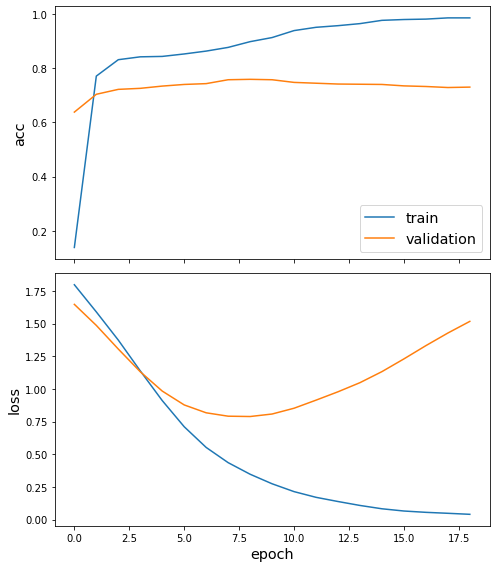

In [8]:
sg.utils.plot_history(nc_hist)

In [9]:
from sklearn.metrics import f1_score

f1_micro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (nc_model.predict(test_flow).squeeze()))), average='micro')
f1_marco = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (nc_model.predict(test_flow).squeeze()))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.729 
f1_macro: 0.666


In [10]:
from sklearn.linear_model import LogisticRegression

tr_tar = list(map(lambda x: np.argmax(x), tr_target.values))
lr = LogisticRegression().fit(features.loc[tr_target.index], tr_tar)

f1_micro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='micro')
f1_macro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.67 
f1_macro: 0.666
